In [187]:
# Import all the necessary packages
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os,re
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import skew,kurtosis

from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn.metrics import mean_squared_error, r2_score,mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [2]:
# Read the file
df = pd.read_excel (r'C:\Users\srika\OneDrive\Desktop\Spring_21\WW_Assesment\sample_data.xlsx')
df.columns = df.iloc[0]
df=df[1:]

In [3]:
len(df)

7083

In [5]:
df.rename(columns={'Sugars, total\n(g)': 'Target'}, inplace=True)

In [6]:
df[df.columns[4:]] = df[df.columns[4:]].astype(float)

# Predict Total Sugar

Building a Model

In [7]:
df.head()

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),Target,"Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
1,11000000,"Milk, human",9602,Human milk,70.0,1.03,6.89,6.89,0.0,4.38,...,0.040,0.0,0.374,0.052,0.0,0.026,0.000,0.000,0.0,87.50
2,11100000,"Milk, NFS",1004,"Milk, reduced fat",51.0,3.34,4.87,4.89,0.0,1.99,...,0.002,0.0,0.069,0.007,0.0,0.003,0.000,0.001,0.0,89.04
3,11111000,"Milk, whole",1002,"Milk, whole",60.0,3.28,4.67,4.81,0.0,3.20,...,0.004,0.0,0.115,0.012,0.0,0.004,0.001,0.002,0.0,88.10
4,11111100,"Milk, low sodium, whole",1002,"Milk, whole",61.0,3.10,4.46,4.46,0.0,3.46,...,0.000,0.0,0.078,0.050,0.0,0.000,0.000,0.000,0.0,88.20
5,11111150,"Milk, calcium fortified, whole",1002,"Milk, whole",60.0,3.28,4.67,4.81,0.0,3.20,...,0.004,0.0,0.115,0.012,0.0,0.004,0.001,0.002,0.0,88.10


# Analyzing Unstructured Data

Structuring WWEIA Category Description Column

In [8]:
df['WWEIA Category description']=df['WWEIA Category description'].apply(lambda x: x.lower())
df['Category Description']=df['WWEIA Category description'].apply(lambda x: x.split(','))
df['Category Des sentence']=df['Category Description'].apply(lambda x: "".join(x))
df['Category Des sentence']=df['Category Des sentence'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['Category Des sentence']=df['Category Des sentence'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['Category Des sentence']=df['Category Des sentence'].apply(lambda x: re.sub(' +',' ',x))

In [9]:
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['Category Des sentence']=df['Category Des sentence'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [10]:
df.head()

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),Target,"Fiber, total dietary (g)",Total Fat (g),...,18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Category Description,Category Des sentence
1,11000000,"Milk, human",9602,human milk,70.0,1.03,6.89,6.89,0.0,4.38,...,0.374,0.052,0.0,0.026,0.000,0.000,0.0,87.50,[human milk],human milk
2,11100000,"Milk, NFS",1004,"milk, reduced fat",51.0,3.34,4.87,4.89,0.0,1.99,...,0.069,0.007,0.0,0.003,0.000,0.001,0.0,89.04,"[milk, reduced fat]",milk reduce fat
3,11111000,"Milk, whole",1002,"milk, whole",60.0,3.28,4.67,4.81,0.0,3.20,...,0.115,0.012,0.0,0.004,0.001,0.002,0.0,88.10,"[milk, whole]",milk
4,11111100,"Milk, low sodium, whole",1002,"milk, whole",61.0,3.10,4.46,4.46,0.0,3.46,...,0.078,0.050,0.0,0.000,0.000,0.000,0.0,88.20,"[milk, whole]",milk
5,11111150,"Milk, calcium fortified, whole",1002,"milk, whole",60.0,3.28,4.67,4.81,0.0,3.20,...,0.115,0.012,0.0,0.004,0.001,0.002,0.0,88.10,"[milk, whole]",milk


Categorizing target variable into three columns (low, neutral, and high)

In [66]:
df['Target_cat']=pd.qcut(df['Target'], 3, labels=['Low sugar','Neutral sugar','High sugar'])

In [67]:
df_grouped=df[['Target_cat','Category Des sentence']].groupby(by='Target_cat').agg(lambda x:' '.join(x))

In [68]:
df_grouped.head()

,Category Des sentence
Target_cat,
Low sugar,milk substitute milk substitute cream cheese s...
Neutral sugar,milk milk milk milk nonfat milk milk nonfat mi...
High sugar,human milk milk reduce fat milk lowfat milk re...


Feature Engineering

In [14]:
from sklearn.feature_extraction import text
cv=text.CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['Category Des sentence'])
df_category_label = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_category_label.index=df_grouped.index
df_category_label.head(3)

,animal,apple,baby,bacon,bagels,bake,bananas,bar,bean,beans,...,turkey,turnover,vegetable,waffles,water,whip,white,wine,yeast,yogurt
Target_cat,,,,,,,,,,,,,,,,,,,,,
Low sugar,13,0,28,12,1,16,0,0,19,33,...,46,17,121,2,10,2,55,4,8,0
Neutral sugar,0,0,80,1,9,32,0,0,24,34,...,2,23,260,17,1,3,93,3,65,7
High sugar,1,10,121,0,20,0,2,46,1,7,...,0,10,119,56,2,9,1,5,49,36


# Exploratory Data Analysis for Unstructured data

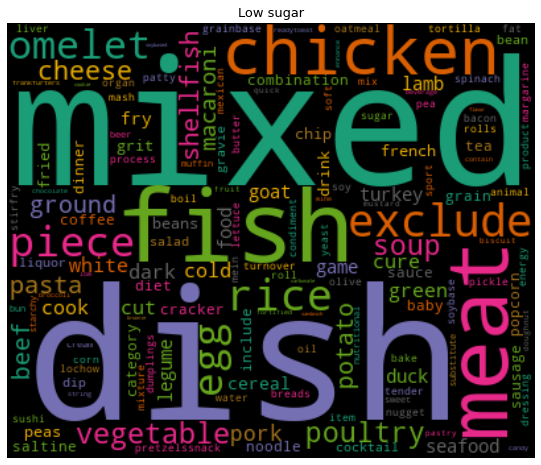

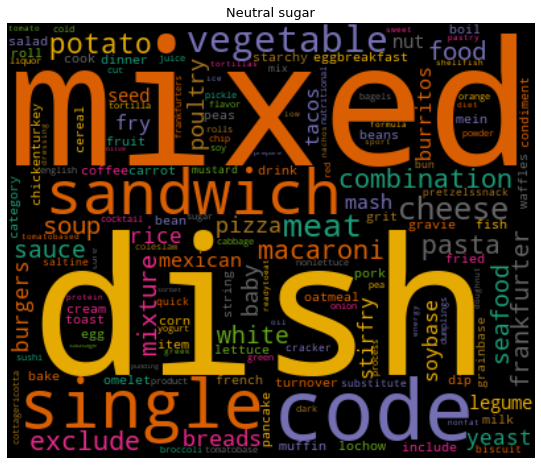

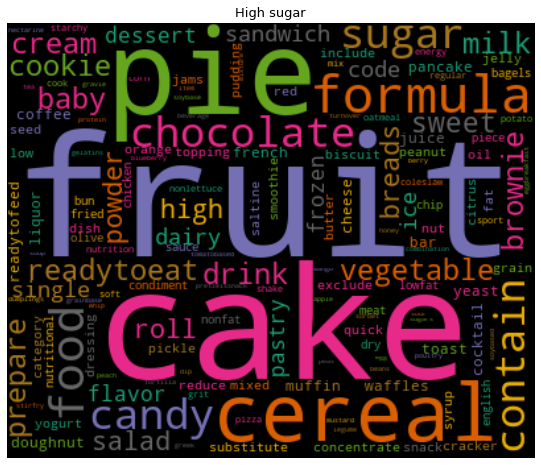

In [15]:
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
df_category_label=df_category_label.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_category_label.columns):
    generate_wordcloud(df_category_label[product].sort_values(ascending=False),product)

Through by above visualizations it can be identified which words conribute more for sugars and the same procedure can be followed for Main Food Description column as well to identify words

Finding correlation between words and sugar content by Bag of Words encoder

In [16]:
from sklearn.feature_extraction import text
cv=text.CountVectorizer(analyzer='word')
data=cv.fit_transform(df['Category Des sentence'])
df_category = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_category.index=df.index
df_category.head(3)

,animal,apple,baby,bacon,bagels,bake,bananas,bar,bean,beans,...,turkey,turnover,vegetable,waffles,water,whip,white,wine,yeast,yogurt
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_category['Target']=df['Target']

In [18]:
df_category.reset_index(drop=True)

,animal,apple,baby,bacon,bagels,bake,bananas,bar,bean,beans,...,turnover,vegetable,waffles,water,whip,white,wine,yeast,yogurt,Target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.89
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.89
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.81
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.46
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.42
7079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.73
7080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.25
7081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.08


In [19]:
df_category[df_category.columns] = df_category[df_category.columns].astype(float)

In [20]:
vals=df_category[df_category.columns].corr()['Target'][:]

In [21]:
corr_dic_category={}
for i,val in enumerate(list(vals)):
    if df_category.columns[i]=='Target':
        continue
    elif val>=0.2 or val<=-0.2:
        corr_dic_category[df_category.columns[i]]=val

below are the words having correlation with Target variable

In [22]:
corr_dic_category

{'brownie': 0.24368346827113418,
 'cake': 0.22303853255742573,
 'candy': 0.4852648475783705,
 'chocolate': 0.4852648475783705,
 'contain': 0.4852648475783705,
 'cookie': 0.24368346827113418,
 'dry': 0.21176236891563086,
 'high': 0.23297195229440426,
 'honey': 0.21471996103984056,
 'jams': 0.20615926371264104,
 'pie': 0.22303853255742573,
 'readytoeat': 0.208086823878382,
 'sugar': 0.22872238562557679,
 'sugars': 0.21471996103984056,
 'syrup': 0.20615926371264104,
 'topping': 0.20615926371264104}

In [23]:
df_unstructured=df_category[list(corr_dic_category.keys())]

In [24]:
corr_dic_category.keys()

dict_keys(['brownie', 'cake', 'candy', 'chocolate', 'contain', 'cookie', 'dry', 'high', 'honey', 'jams', 'pie', 'readytoeat', 'sugar', 'sugars', 'syrup', 'topping'])

In [25]:
df_unstructured.head()

,brownie,cake,candy,chocolate,contain,cookie,dry,high,honey,jams,pie,readytoeat,sugar,sugars,syrup,topping
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Analyzing structured data

In [26]:
df_structured=df[df.columns[4:]]

In [27]:
df_structured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7083 entries, 1 to 7083
Data columns (total 68 columns):
Energy (kcal)                             7083 non-null float64
Protein (g)                               7083 non-null float64
Carbohydrate (g)                          7083 non-null float64
Target                                    7083 non-null float64
Fiber, total dietary (g)                  7083 non-null float64
Total Fat (g)                             7083 non-null float64
Fatty acids, total saturated (g)          7083 non-null float64
Fatty acids, total monounsaturated (g)    7083 non-null float64
Fatty acids, total polyunsaturated (g)    7083 non-null float64
Cholesterol (mg)                          7083 non-null float64
Retinol (mcg)                             7083 non-null float64
Vitamin A, RAE (mcg_RAE)                  7083 non-null float64
Carotene, alpha (mcg)                     7083 non-null float64
Carotene, beta (mcg)                      7083 non-null float

All the data is of float type

# Exploratory Data Analysis for Structured Data

<AxesSubplot:xlabel='Target', ylabel='Count'>

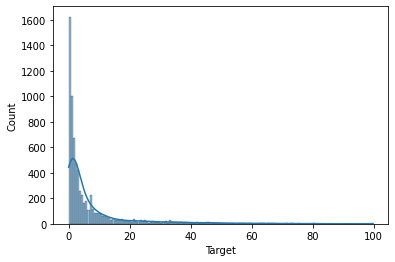

In [28]:
#import seaborn as sns
#plt.figure(figsize=(10,6))
sns.histplot(df_structured.Target,kde=True)
#plt.figure(figsize=(6, 3))
#plt.show()

Finding more correlated features among all the features through heatmap

As the dimensionality is high, I want to calculate correlated features which are not falling in the range (-0.2,0.2) and visualize them

In [2]:
# Calculating correlation between Target and all other numerical columns
vals_structured=df_structured[df_structured.columns].corr()['Target'][:]

In [30]:
# Arranging in a dictionary of column name and correlation value having considerable correlation
corr_dic_structured={}
for i,val in enumerate(list(vals_structured)):
    if df_structured.columns[i]=='Target':
        continue
    elif val>=0.2 or val<=-0.2:
        corr_dic_structured[df_structured.columns[i]]=val

In [31]:
corr_dic_structured

{'Energy (kcal)': 0.3938526678168695,
 'Protein (g)': -0.22734141016999687,
 'Carbohydrate (g)': 0.6864409601153766,
 'Theobromine (mg)': 0.2838354949159723,
 'Water\n(g)': -0.5109783516137615}

So from the above depiction I found these 5 features are correlated with "Target" Feature 

In [32]:
df_corr=df_structured[['Energy (kcal)','Protein (g)','Carbohydrate (g)','Theobromine (mg)','Water\n(g)','Target']]

Heatmap to analyze all correlated values

<AxesSubplot:xlabel='0', ylabel='0'>

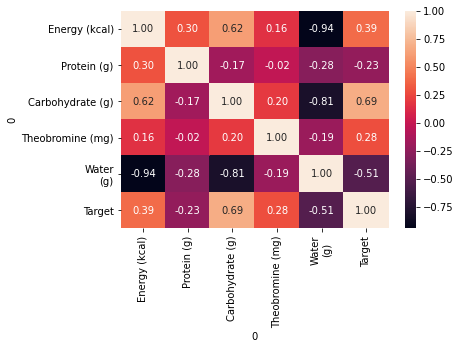

In [33]:
sns.heatmap(df_corr.corr(),annot=True,fmt=".2f")
#plt.show()

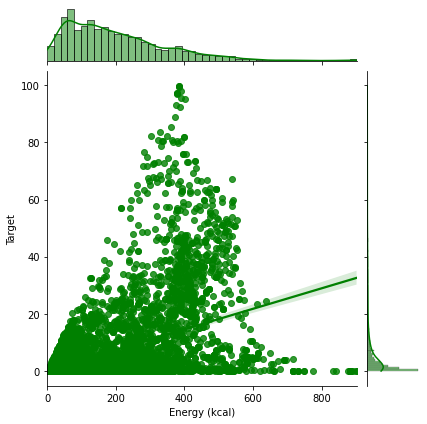

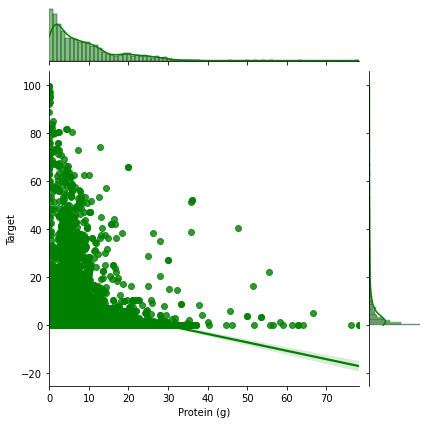

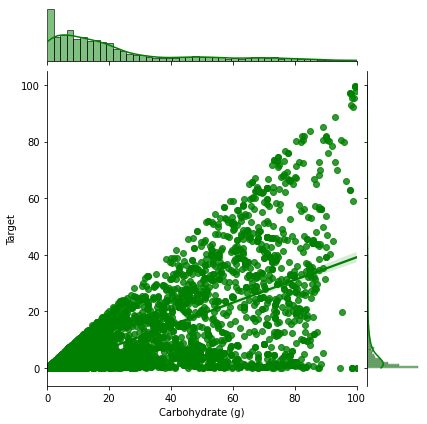

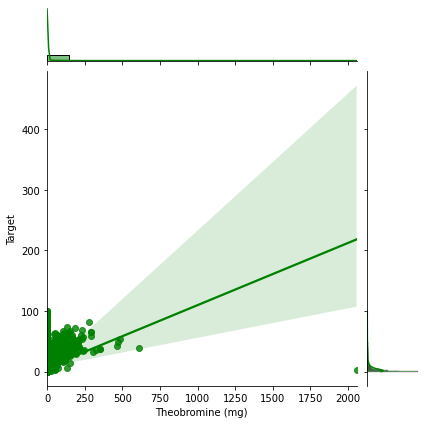

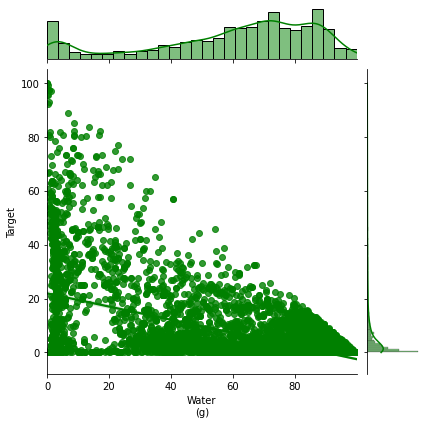

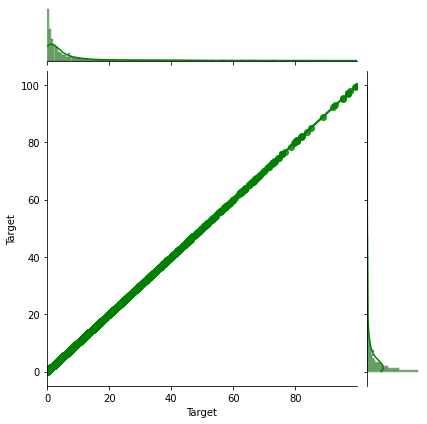

In [34]:
for col in df_corr.columns:
    sns.jointplot(data=df_corr,x=col,y='Target',kind='reg',color='g')

# Feature Engineering

In the above figures it shows each feature correlation with response variable

After performing EDA, figuring out correlated features the derived features are as follows

From structured data: 'Energy (kcal)','Protein (g)','Carbohydrate (g)','Theobromine (mg)','Water\n(g)'

From unstructured data: 'brownie', 'cake', 'candy', 'chocolate', 'contain', 'cookie', 'dry', 'high', 'honey', 'jams', 'pie', 'readytoeat', 'sugar', 'sugars', 'syrup', 'topping'

In [35]:
df.head()

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),Target,"Fiber, total dietary (g)",Total Fat (g),...,18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g),Category Description,Category Des sentence,Target_cat
1,11000000,"Milk, human",9602,human milk,70.0,1.03,6.89,6.89,0.0,4.38,...,0.052,0.0,0.026,0.000,0.000,0.0,87.50,[human milk],human milk,High sugar
2,11100000,"Milk, NFS",1004,"milk, reduced fat",51.0,3.34,4.87,4.89,0.0,1.99,...,0.007,0.0,0.003,0.000,0.001,0.0,89.04,"[milk, reduced fat]",milk reduce fat,High sugar
3,11111000,"Milk, whole",1002,"milk, whole",60.0,3.28,4.67,4.81,0.0,3.20,...,0.012,0.0,0.004,0.001,0.002,0.0,88.10,"[milk, whole]",milk,Neutral sugar
4,11111100,"Milk, low sodium, whole",1002,"milk, whole",61.0,3.10,4.46,4.46,0.0,3.46,...,0.050,0.0,0.000,0.000,0.000,0.0,88.20,"[milk, whole]",milk,Neutral sugar
5,11111150,"Milk, calcium fortified, whole",1002,"milk, whole",60.0,3.28,4.67,4.81,0.0,3.20,...,0.012,0.0,0.004,0.001,0.002,0.0,88.10,"[milk, whole]",milk,Neutral sugar


In [137]:
#Concatenating data frame structured and unstructured
df_final=pd.concat([df_corr,df_unstructured],axis=1)

In [138]:
df_unstructured.head()

,brownie,cake,candy,chocolate,contain,cookie,dry,high,honey,jams,pie,readytoeat,sugar,sugars,syrup,topping
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
df_final.head()

,Energy (kcal),Protein (g),Carbohydrate (g),Theobromine (mg),Water\n(g),Target,brownie,cake,candy,chocolate,...,dry,high,honey,jams,pie,readytoeat,sugar,sugars,syrup,topping
1,70.0,1.03,6.89,0.0,87.50,6.89,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.0,3.34,4.87,0.0,89.04,4.89,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60.0,3.28,4.67,0.0,88.10,4.81,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61.0,3.10,4.46,0.0,88.20,4.46,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,60.0,3.28,4.67,0.0,88.10,4.81,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
df_final.columns

Index(['Energy (kcal)', 'Protein (g)', 'Carbohydrate (g)', 'Theobromine (mg)',
       'Water\n(g)', 'Target', 'brownie', 'cake', 'candy', 'chocolate',
       'contain', 'cookie', 'dry', 'high', 'honey', 'jams', 'pie',
       'readytoeat', 'sugar', 'sugars', 'syrup', 'topping'],
      dtype='object')

# Model Building and Evaluation

Removing outliers

In [141]:
print(df_final['Target'].quantile(0.015))
print(df_final['Target'].quantile(0.9985))
index = df_final[(df_final['Target'] >90.18557000000139)|(df_final['Target'] < 0.0)].index
df_final.drop(index, inplace=True)

0.0
90.18557000000139


In [142]:
len(df_final)

7072

In [191]:
# Partition the dataset in train + validation sets
from sklearn.model_selection import train_test_split #to create validation data set
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('Target',axis=1), df_final['Target'], test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (4950, 21)
X_test : (2122, 21)
y_train : (4950,)
y_test : (2122,)


Linear Regression

In [192]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [193]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [194]:
mse_train = np.mean((y_train_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lm.score(X_test,y_test))

MSE on Training set :  45.38249172215142
MSE on Test set :  48.196213346437986
0.6729641190725297


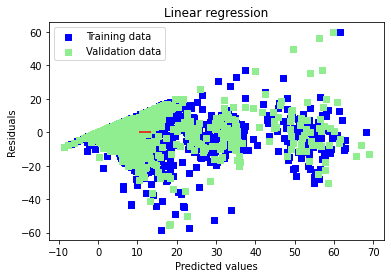

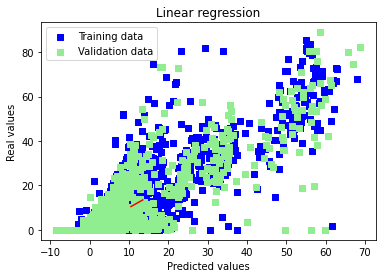

In [195]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

RidgeCV

In [173]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 30, 40, 50, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 0.01


In [174]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-15, 1.e-10, 1.e-08, 1.e-04, 1.e-03, 1.e-02, 1.e+00, 5.e+00,
       1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [175]:
y_train_ridge_pred = ridge.predict(X_train)
y_test_ridge_pred = ridge.predict(X_test)

In [176]:
mse_train = np.mean((y_train_ridge_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_ridge_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(ridge.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  47.612402544060586
MSE on Test set :  43.65528096056109
0.7180849432722498


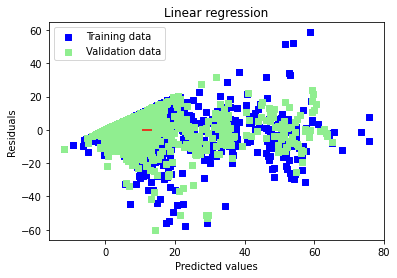

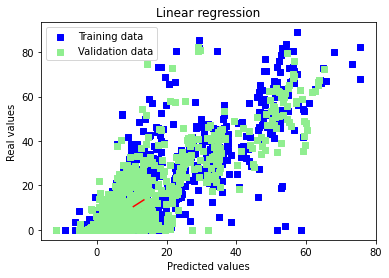

In [177]:
# Plot residuals
plt.scatter(y_train_ridge_pred, y_train_ridge_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test_ridge_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_ridge_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Ridge picked 21 features and eliminated the other 0 features


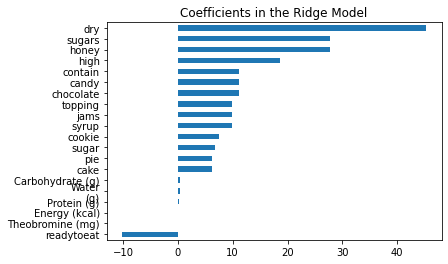

In [178]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [179]:
from sklearn.linear_model import LassoCV


lasso = LassoCV(alphas = [0.0001, 0.0002,0.0004, 0.0006, 0.001, 0.002,0.004, 0.006, 0.01, 0.02,0.04, 0.06, 0.1, 
                          0.2,0.4, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.004


In [180]:
lasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.0002, 0.0004, 0.0006, 0.001, 0.002, 0.004, 0.006,
                0.01, 0.02, 0.04, 0.06, 0.1, 0.2, 0.4, 0.6, 1],
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=50000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [181]:
y_train_lasso_pred = lasso.predict(X_train)
y_test_lasso_pred = lasso.predict(X_test)

In [182]:
mse_train = np.mean((y_train_lasso_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_lasso_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lasso.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  47.71857501876994
MSE on Test set :  44.47655506515844
0.7127813572984071


Lasso picked 20 features and eliminated the other 1 features


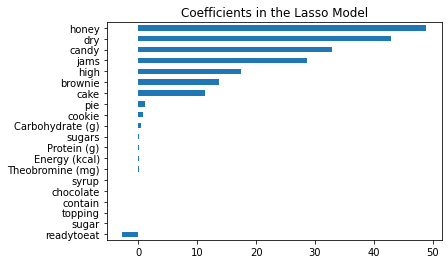

In [183]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

XGBoost

In [184]:
from xgboost import XGBRegressor

In [185]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

In [188]:
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_gri

In [189]:
y_train_xgb_pred = grid.predict(X_train)
y_test_xgb_pred = grid.predict(X_test)

In [190]:
mse_train = np.mean((y_train_xgb_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_xgb_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(grid.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  9.579753248977763
MSE on Test set :  26.967582081923066
0.8258499942010707


# Conclusion and Assumptions

I categorized whole dataset into structured and unstructured data
1. For structured data through by correlation and visualizations I found these features are important 'Energy (kcal)','Protein (g)','Carbohydrate (g)','Theobromine (mg)','Water\n(g)
2. For unstructured data I have used bag of words as encoder and have done visualizations which ingredients contribute more for High sugar, Neutral sugar, Low sugar
3. Sending these features into model to check accuracy
4. After model building is done and evaluating model performance I found out XGBoost performs well with an accuracy of 82.5% with test set size taken as 0.33

Now the weights got optimized and same model can be used for Brazilian dataset

What more can be done:

1. Can build classification model as I already have categorized the "sugar content" into ["high sugar, low sugar, neutral sugar"]
2. The accuracy can be acheived much higher with the above model
3. For unstructured data these can be further implemented Topic modelling, GloVe, BERT emneddings for similarity checking  

# Rank Fruit Sweetness

There are only 2 columns containing unstructured data and one among them just describes category containing no detailed description of which fruit it is. So, I considered Main food description as key entity

Preprocessing

In [36]:
df['Main food description']=df['Main food description'].apply(lambda x: x.lower())
df['Main food sentence']=df['Main food description'].apply(lambda x: x.split(','))
df['Main food sentence']=df['Main food sentence'].apply(lambda x: "".join(x))
df['Main food sentence']=df['Main food sentence'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['Main food sentence']=df['Main food sentence'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['Main food sentence']=df['Main food sentence'].apply(lambda x: re.sub(' +',' ',x))

In [37]:
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['Main food sentence']=df['Main food sentence'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [196]:
#Defining all types of fruits in dictionary
all_fruits=["salad","apple","banana","grape","peach","strawberry","blueberry","citrus","melon","dry","pear","pineapple","mango","papaya"]

In [52]:
fruit_dic={}
for i,val in enumerate(df["Main food sentence"]):
    #print(type(val))
    for fruit in all_fruits:
        if fruit in val:
            #print(fruit)
            if fruit not in fruit_dic:
                #print(fruit_dic)
                fruit_dic[fruit]=[float(df.iloc[i]['Target'])]
            else:
                #print("yes")
                
                #print(i,fruit_dic)
                fruit_dic[fruit]+=[float(df.iloc[i]['Target'])]

In [55]:
for x,y in fruit_dic.items():
    print("--------------------")
    print(x,y)

--------------------
dry [4.6, 5.86, 4.55, 4.6, 9.63, 9.55, 9.62, 9.69, 9.77, 8.99, 9.63, 9.55, 9.62, 9.69, 9.77, 8.99, 5.86, 5.78, 5.86, 5.92, 6.01, 5.2, 8.93, 12.87, 12.94, 13.0, 13.08, 12.31, 3.11, 7.45, 7.52, 7.59, 7.67, 6.88, 51.98, 38.42, 51.46, 51.98, 74.46, 81.82, 27.27, 72.73, 95.45, 14.91, 19.43, 16.63, 4.66, 4.57, 0.07, 0.78, 1.5, 1.85, 1.83, 2.7, 2.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.59, 2.58, 0.31, 0.33, 0.34, 0.3, 0.32, 2.7, 0.32, 0.34, 0.32, 0.32, 3.07, 4.46, 4.77, 2.88, 2.7, 1.67, 1.79, 16.42, 4.9, 4.88, 4.9, 1.85, 1.58, 13.2, 26.66, 11.67, 4.85, 3.22, 1.35, 16.7, 0.72, 6.68, 26.67, 26.66, 11.09, 26.66, 2.24, 66.33, 57.19, 53.44, 67.5, 67.15, 62.28, 72.56, 47.9, 66.27, 67.55, 41.74, 62.2, 80.06, 72.94, 38.13, 44.9, 2.21, 2.18, 0.27, 1.59, 1.59, 1.45, 1.33, 3.83, 3.04, 19.81, 0.2, 1.59, 4.63, 5.53, 95.29, 97.15]
--------------------
strawberry [5.29, 11.68, 10.46, 11.82, 11.9, 6.86, 11.12, 95.45, 17.32, 21.59, 16.0, 17.5, 11.81, 15.34, 16.98, 14.81, 2

Calculating the mean value for each fruit

In [201]:
import scipy
fruit_mean={}
for x,val in fruit_dic.items():
    fruit_mean[x]=scipy.mean(fruit_dic[x])
#print(fruit_mean)
fruit_mean={k: v for k, v in sorted(fruit_mean.items(), key=lambda item: item[1])}

C:\Python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  after removing the cwd from sys.path.


In [216]:
fruit_mean

{'salad': 3.513058823529412,
 'melon': 4.321428571428571,
 'grape': 8.779411764705882,
 'citrus': 9.798947368421054,
 'pear': 12.547391304347828,
 'banana': 14.12452380952381,
 'apple': 14.948000000000002,
 'peach': 15.380833333333333,
 'dry': 17.322573529411763,
 'pineapple': 18.654285714285713,
 'strawberry': 19.72904761904762,
 'mango': 22.379999999999995,
 'papaya': 22.81,
 'blueberry': 23.555333333333337}

In [ ]:
# import matplotlib.pylab as plt

lists = fruit_mean.items() # return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(18,9))
plt.plot(x, y)
plt.show()

Calculating the median value for each fruit

In [212]:
fruit_median={}
for x,val in fruit_dic.items():
    fruit_median[x]=scipy.median(fruit_dic[x])
#print(fruit_mean)
fruit_median={k: v for k, v in sorted(fruit_median.items(), key=lambda item: item[1])}

C:\Python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [217]:
fruit_median

{'salad': 2.355,
 'melon': 5.69,
 'dry': 5.86,
 'pear': 8.43,
 'grape': 8.75,
 'citrus': 9.65,
 'pineapple': 10.28,
 'apple': 10.7,
 'peach': 11.695,
 'banana': 12.495000000000001,
 'mango': 13.66,
 'papaya': 13.91,
 'strawberry': 14.81,
 'blueberry': 17.32}

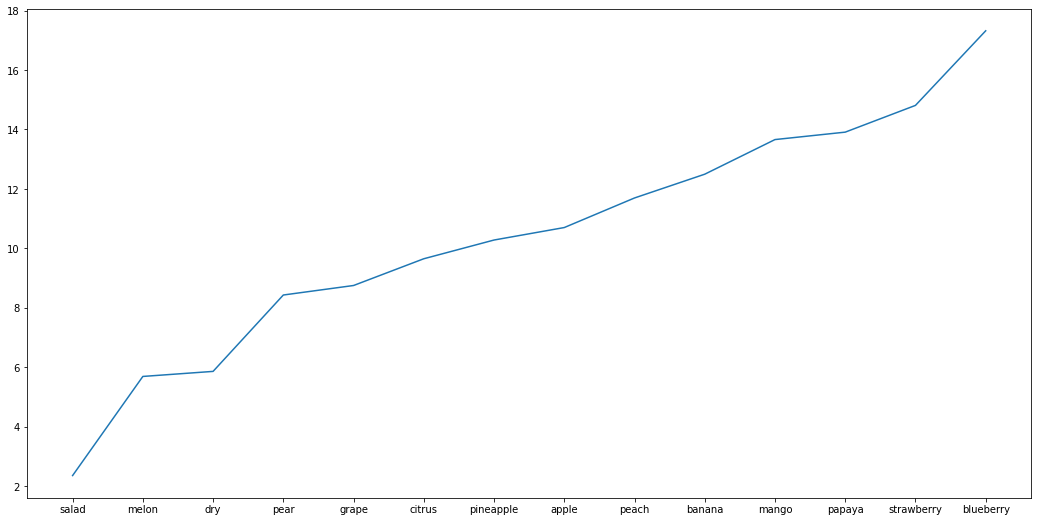

In [213]:
import matplotlib.pylab as plt

lists = fruit_median.items() # return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(18,9))
plt.plot(x, y)
plt.show()

# Conclusion

With both mean and median, salad having least sugar content where as blueberry having more sugar content and remaining all other fruits slightly varying the positions 